Run Compositional Data Analysis following scCoda Bayesian approach. For that I will use the whole dataset, with whole cells and then I will annotate the Barcodes of T cells based on the subclustering I have performed. 
https://www.nature.com/articles/s41467-021-27150-6

Compositional data are nonnegative data carrying relative, rather than absolute, information—these are often data with a constant-sum constraint on the sample values, for example, proportions or percentages summing to 1% or 100%, respectively. Ratios between components of a composition are important since they are unaffected by the particular set of components chosen. Logarithms of ratios (logratios) are the fundamental transformation in the ratio approach to compositional data analysis—all data thus need to be strictly positive, so that zero values present a major problem.

https://www.annualreviews.org/doi/pdf/10.1146/annurev-statistics-042720-124436

By “compositional,” we mean that the abun- dance of any 1 nucleotide fragment is only interpretable rela- tive to another. This property emerges from the sequencer it- self; the sequencer, by design, can only sequence a fixed num- ber of nucleotide fragments. Consequently, the final number of fragments sequenced is constrained to an arbitrary limit so that doubling the input material does not double the total number of counts. This constraint also means that an increase in the pres- ence of any 1 nucleotide fragment necessarily decreases the ob- served abundance of all other transcripts, and applies to bulk and single-cell sequencing data alike. It is especially problem- atic when comparing cells that produce more total RNA than their comparator (e.g., high–c-Myc cells, which up-regulate 90% of all transcripts without commensurate down-regulation). However, even if a sequencer could directly sequence every RNA molecule within a cell, the cells themselves are compositional because of the volume and energy constraints that limit RNA synthesis, as evidenced by the observation that smaller cells of a single type contain proportionally less total messenger RNA (mRNA).

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6755255/pdf/giz107.pdf


In [1]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns


from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd
import anndata as ad

from scanpro import scanpro, anova, t_test
from scanpro.linear_model import create_design
from scanpro.get_transformed_props import get_transformed_props


2024-12-05 14:53:27.626135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load harmony integrated data.
harmony_int_annot = '../harmony_integrated_annotated.h5ad'

# Read the HDF5 file into a DataFrame
integrated_harmony = ad.read_h5ad(harmony_int_annot)

In [3]:
#load tcell data.
t_cell_re_clustered = '../t_cell_analysis/t_cell_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
t_cell_data = ad.read_h5ad(t_cell_re_clustered)

In [4]:
#now add t cell annotation to the observation part
t_cell_data.obs['Barcodes']=t_cell_data.obs.index

In [5]:
t_data_info=t_cell_data.obs[['Barcodes','T_cell_type_fine']]
#rename T_cell_type_fine to concat with macrophages
t_data_info = t_data_info.rename(columns={'T_cell_type_fine': 'New_clustering'})

In [6]:
#sine t data is not the only one we have reclustered load also megacaryocytes data. 
#load megacaryocytes data.
macrophages_clustered = '../macrophages_data/macrophages_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
macrophages_data = ad.read_h5ad(macrophages_clustered)
macrophages_data.obs['Barcodes']=macrophages_data.obs.index


In [7]:
macro_info=macrophages_data.obs[['Barcodes','Myeloid_granular']]
macro_info = macro_info.rename(columns={'Myeloid_granular': 'New_clustering'})

In [8]:
#concat tcells and macrophages
concated_data=pd.concat([t_data_info, macro_info], ignore_index=True)

In [9]:
integrated_harmony.obs['Barcodes']=integrated_harmony.obs.index

In [10]:
#i need to add the bcells too since we have change the annoation.

bceels_clustered = '../b_cell_analysis/b_cell_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
bcell_data = ad.read_h5ad(bceels_clustered)
bcell_data.obs['Barcodes']=bcell_data.obs.index


In [11]:
bcell_info=bcell_data.obs[['Barcodes','Cell_type_generic_3']]
bcell_info = bcell_info.rename(columns={'Cell_type_generic_3': 'New_clustering'})

In [12]:
#concat all cells types
concated_data2=pd.concat([concated_data, bcell_info], ignore_index=True)


In [13]:
new_integrated_harmony=integrated_harmony.copy()

In [14]:
sorted_barcodes = new_integrated_harmony.obs.index

In [15]:
new_integrated_harmony.obs = pd.merge(new_integrated_harmony.obs,concated_data2, on='Barcodes', how='outer')

In [16]:
new_integrated_harmony.obs.index=new_integrated_harmony.obs['Barcodes']

In [17]:
#now sort again the table based on barcodes because when merging everything changed
new_integrated_harmony.obs=new_integrated_harmony.obs.reindex(sorted_barcodes)

In [18]:
new_integrated_harmony.obs['New_clustering'] = new_integrated_harmony.obs['New_clustering'].astype(str)
new_integrated_harmony.obs['Cell_type_generic_2'] = new_integrated_harmony.obs['Cell_type_generic_2'].astype(str)

In [19]:
new_integrated_harmony.layers['log10']=new_integrated_harmony.raw.X.copy() #in our case we already have the normalized log transformed in .raw

In [20]:
new_integrated_harmony.obs.loc[new_integrated_harmony.obs['New_clustering']=='nan', 'New_clustering'] = new_integrated_harmony.obs['Cell_type_generic_2']

In [22]:
new_integrated_harmony.obs['Cell_type_generic'].unique()

['B_cells', 'Treg', 'T_cells', 'NK', 'Macrophages', 'Eosinophils', 'B_memory', 'Plasma']
Categories (8, object): ['B_cells', 'B_memory', 'Eosinophils', 'Macrophages', 'NK', 'Plasma', 'T_cells', 'Treg']

In [23]:
new_integrated_harmony.obs.loc[new_integrated_harmony.obs['New_clustering'] == 'Naive_1', 'New_clustering'] = 'T_Naive_1'
new_integrated_harmony.obs.loc[new_integrated_harmony.obs['New_clustering'] == 'Naive_2', 'New_clustering'] = 'T_Naive_2'
new_integrated_harmony.obs['Cell_type_generic'] = new_integrated_harmony.obs['Cell_type_generic'].replace({
    'B_cells': 'B cells',
    'B_memory': 'B memory',
    'Eosinophils': 'EOS',
    'Macrophages':'MF',
    'NK': 'NK cells',
    'Plasma':'Plasma cells',
    'T_cells':'T cells',
    'Treg': 'T regs',
})

In [24]:
# using scanpro i can get by default number of cell per sample in a dataframe
counts, props, prop_trans = get_transformed_props(new_integrated_harmony, sample_col='Sample', cluster_col='Cell_type_generic', transform='logit')


In [25]:
props

Cell_type_generic,B cells,B memory,EOS,MF,NK cells,Plasma cells,T cells,T regs
Sample,,,,,,,,
out_Mouse_4,0.692851,0.084456,0.000385,0.009370,0.011680,0.004621,0.135541,0.061096
out_Mouse_5,0.167978,0.016601,0.005534,0.029759,0.050910,0.007747,0.504304,0.217167
out_Mouse_8,0.394521,0.132877,0.003611,0.018182,0.037360,0.010710,0.192030,0.210710
out_Mouse_11,0.085043,0.008273,0.001655,0.031216,0.050739,0.007721,0.590117,0.225237
out_Mouse_13,0.232773,0.030192,0.000365,0.006331,0.026418,0.002922,0.523375,0.177624
out_Mouse_23,0.458729,0.082541,0.000801,0.005610,0.019462,0.011563,0.326961,0.094333


In [26]:
counts['Sample']=pd.DataFrame(counts).index

In [27]:
counts

Cell_type_generic,B cells,B memory,EOS,MF,NK cells,Plasma cells,T cells,T regs,Sample
Sample,,,,,,,,,
out_Mouse_4,5398,658,3,73,91,36,1056,476,out_Mouse_4
out_Mouse_5,1366,135,45,242,414,63,4101,1766,out_Mouse_5
out_Mouse_8,3168,1067,29,146,300,86,1542,1692,out_Mouse_8
out_Mouse_11,771,75,15,283,460,70,5350,2042,out_Mouse_11
out_Mouse_13,1912,248,3,52,217,24,4299,1459,out_Mouse_13
out_Mouse_23,4007,721,7,49,170,101,2856,824,out_Mouse_23


In [28]:
sccoda_anndata= dat.from_pandas(counts, covariate_columns=["Sample"])
#now add to observation the condition of each mouse
sccoda_anndata

AnnData object with n_obs × n_vars = 6 × 8
    obs: 'Sample'

In [29]:
# add information of the condition of each mouse sample. So to merged_data.obs add a new column that will display cart or cart+radiation
sccoda_anndata.obs["Condition"] = "Cy/mCART19"

# Define conditions for specific samples
conditions = {
    "out_Mouse_5": "Cy/LD-TBI/mCART19",
    "out_Mouse_11": "Cy/LD-TBI/mCART19",
    "out_Mouse_13": "Cy/LD-TBI/mCART19",
}

# Update 'Condition' column based on conditions
for sample, condition in conditions.items():
    sccoda_anndata.obs['Condition'] = np.where(sccoda_anndata.obs['Sample'] == sample, condition, sccoda_anndata.obs['Condition'])

The scCODA model requires a cell type to be set as the reference category. However, choosing this cell type is often difficult. A good first choice is a referenece cell type that closely preserves the changes in relative abundance during the compositional analysis.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes. Also, the relative abundance of the reference should vary as little as possible across all samples.

The visualization viz.rel_abundance_dispersion_plot shows the presence (share of non-zero samples) over all samples for each cell type versus its dispersion in relative abundance. Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.

Model setup and inference

The formula parameter. It specifies how the covariates are used in the model. It can process R-style formulas via the patsy package, e.g. formula="Cov1 + Cov2 + Cov3". Here, we simply use the “Condition” covariate of our dataset

The reference_cell_type parameter is used to specify a cell type that is believed to be unchanged by the covariates in formula. This is necessary, because compositional analysis must always be performed relative to a reference (See Büttner, Ostner et al., 2021 for a more thorough explanation). If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice. It is also possible to let scCODA find a suited reference cell type by using reference_cell_type="automatic". Here, we take Goblet cells as the reference.

In [30]:
import tensorflow as tf
tf.random.set_seed(0)
model_sccoda_anndata = mod.CompositionalAnalysis(sccoda_anndata, formula="Condition", reference_cell_type="automatic")


Automatic reference selection! Reference cell type set to Plasma cells


In [31]:
# Run MCMC
sccoda_anndata_results = model_sccoda_anndata.sample_hmc()

  0%|                                                                                       | 0/20000 [00:00<?, ?it/s]2024-12-05 15:02:03.879737: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbf0029aec0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-12-05 15:02:03.879764: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-12-05 15:02:03.929498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733428924.388794  173107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-05 15:02:04.404660: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
100%|████████████████████████████████████████████████████████████████████████

MCMC sampling finished. (66.524 sec)
Acceptance rate: 62.6%


In [32]:
sccoda_anndata_results.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 5
Formula: Condition

Intercepts:
              Final Parameter  Expected Sample
Cell Type                                     
B cells                 2.170      1348.202799
B memory                0.392       227.813594
EOS                    -1.056        53.545284
MF                      0.166       181.731028
NK cells                0.797       341.561491
Plasma cells           -0.316       112.227462
T cells                 3.352      4396.340303
T regs                  2.382      1666.578039


Effects:
                                      Final Parameter  Expected Sample  \
Covariate               Cell Type                                        
Condition[T.Cy/mCART19] B cells                   0.0      1348.202799   
                        B memory                  0.0       227.813594   
                        EOS                       0.0        53.545284   
                        MF         

In [33]:
print(sccoda_anndata_results.credible_effects())


Covariate                Cell Type   
Condition[T.Cy/mCART19]  B cells         False
                         B memory        False
                         EOS             False
                         MF              False
                         NK cells        False
                         Plasma cells    False
                         T cells         False
                         T regs          False
Name: Final Parameter, dtype: bool


In [34]:

sccoda_anndata_results.set_fdr(est_fdr=0.15)
sccoda_anndata_results.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 5
Formula: Condition

Intercepts:
              Final Parameter  Expected Sample
Cell Type                                     
B cells                 2.170      1348.202799
B memory                0.392       227.813594
EOS                    -1.056        53.545284
MF                      0.166       181.731028
NK cells                0.797       341.561491
Plasma cells           -0.316       112.227462
T cells                 3.352      4396.340303
T regs                  2.382      1666.578039


Effects:
                                      Final Parameter  Expected Sample  \
Covariate               Cell Type                                        
Condition[T.Cy/mCART19] B cells              1.230907      4090.165996   
                        B memory             1.354864       782.346753   
                        EOS                  0.000000        47.438482   
                        MF         

In [53]:
res_scoda_fdr0_0_5=sccoda_anndata_results.effect_df
res_scoda_fdr0_0_5

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate               Cell Type                                               
Condition[T.Cy/mCART19] B cells              1.230907   0.241    2.193  0.620   
                        B memory             1.354864   0.163    2.634  0.739   
                        EOS                  0.000000  -1.269    1.097  0.398   
                        MF                   0.000000  -1.521    0.723  0.446   
                        NK cells             0.000000  -1.762    0.693  0.559   
                        Plasma cells         0.000000   0.000    0.000  0.000   
                        T cells             -1.045961  -2.020    0.024  0.634   
                        T regs               0.000000  -1.899    0.147  0.610   

                                      Inclusion probability  Expected Sample  \
Covariate               Cell Type                                              
Condition[T.Cy/mCART19] B cells                    0.904333      4090.165996   
                        B memory                   0.893333       782.346753   
                        EOS                        0.426333        47.438482   
                        MF                         0.446067       161.004731   
                        NK cells                   0.510000       302.606641   
                        Plasma cells               0.000000        99.427998   
                        T cells                    0.847733      1368.503425   
                        T regs                     0.610533      1476.505975   

                                      log2-fold change  
Covariate               Cell Type                       
Condition[T.Cy/mCART19] B cells               1.601122  
                        B memory              1.779954  
                        EOS                  -0.174702  
                        MF                   -0.174702  
                        NK cells             -0.174702  
                        Plasma cells         -0.174702  
                        T cells              -1.683704  
                        T regs               -0.174702

In [54]:
#get results from object
# Subset the dataframe based on a single row name (index)
res_dataframe = res_scoda_fdr0_0_5.loc[
    ("Condition[T.Cy/mCART19]", slice(None))  # The slice(None) allows for all values in the second level
]


In [55]:
#plot proportions using 
melted_prop=pd.melt(props, var_name="cell_type", value_name="proportion")
melted_prop["Sample_name"]=props.index.tolist() * len(props.columns)
melted_prop
#melted_prop.to_csv('ALL_data_prop.csv', index=False)

,cell_type,proportion,Sample_name
0,B cells,0.692851,out_Mouse_4
1,B cells,0.167978,out_Mouse_5
2,B cells,0.394521,out_Mouse_8
3,B cells,0.085043,out_Mouse_11
4,B cells,0.232773,out_Mouse_13
5,B cells,0.458729,out_Mouse_23
6,B memory,0.084456,out_Mouse_4
7,B memory,0.016601,out_Mouse_5
8,B memory,0.132877,out_Mouse_8
9,B memory,0.008273,out_Mouse_11


In [56]:
design = create_design(data=new_integrated_harmony, sample_col='Sample', conds_col='Condition')
design

,CART_RAD,CART
Sample,,
out_Mouse_11,1.0,0.0
out_Mouse_13,1.0,0.0
out_Mouse_23,0.0,1.0
out_Mouse_4,0.0,1.0
out_Mouse_5,1.0,0.0
out_Mouse_8,0.0,1.0


In [57]:
conditions=new_integrated_harmony.obs[["Sample", "Condition"]].drop_duplicates()
conditions=conditions.rename(columns={"Sample": "Sample_name"})
melted_prop = pd.merge(melted_prop,conditions)


In [58]:
melted_prop['Condition'] = melted_prop['Condition'].replace("CART", "Cy/mCART19")
melted_prop['Condition'] = melted_prop['Condition'].replace("CART_RAD", "Cy/LD-TBI/mCART19")
melted_prop

,cell_type,proportion,Sample_name,Condition
0,B cells,0.692851,out_Mouse_4,Cy/mCART19
1,B cells,0.167978,out_Mouse_5,Cy/LD-TBI/mCART19
2,B cells,0.394521,out_Mouse_8,Cy/mCART19
3,B cells,0.085043,out_Mouse_11,Cy/LD-TBI/mCART19
4,B cells,0.232773,out_Mouse_13,Cy/LD-TBI/mCART19
5,B cells,0.458729,out_Mouse_23,Cy/mCART19
6,B memory,0.084456,out_Mouse_4,Cy/mCART19
7,B memory,0.016601,out_Mouse_5,Cy/LD-TBI/mCART19
8,B memory,0.132877,out_Mouse_8,Cy/mCART19
9,B memory,0.008273,out_Mouse_11,Cy/LD-TBI/mCART19


In [59]:
scoda_Res_df = res_dataframe[['Final Parameter']]
scoda_Res_df["cell_type"]=scoda_Res_df.index 
scoda_Res_df

,Final Parameter,cell_type
Cell Type,,
B cells,1.230907,B cells
B memory,1.354864,B memory
EOS,0.000000,EOS
MF,0.000000,MF
NK cells,0.000000,NK cells
Plasma cells,0.000000,Plasma cells
T cells,-1.045961,T cells
T regs,0.000000,T regs


In [60]:
melted_prop=pd.merge(melted_prop,scoda_Res_df)

In [61]:
melted_prop['Condition'] = pd.Categorical(melted_prop['Condition'], categories=['Cy/mCART19','Cy/LD-TBI/mCART19'], ordered=True)
#melted_prop['cell_type'] = pd.Categorical(melted_prop['cell_type'], categories=['B_cells', 'B_memory', 'Eosinophils','Macrophages','NK','Plasma', 'T_cells','Treg'], ordered=False)
melted_prop = melted_prop.sort_values(by='cell_type')
melted_prop['cell_type'] = pd.Categorical(
    melted_prop['cell_type'], 
    categories=['B cells','B memory','EOS','MF','NK cells','Plasma cells','T cells','T regs'], 
    ordered=True
)
melted_prop.reset_index(drop=True, inplace=True)
melted_prop

,cell_type,proportion,Sample_name,Condition,Final Parameter
0,B cells,0.692851,out_Mouse_4,Cy/mCART19,1.230907
1,B cells,0.167978,out_Mouse_5,Cy/LD-TBI/mCART19,1.230907
2,B cells,0.394521,out_Mouse_8,Cy/mCART19,1.230907
3,B cells,0.085043,out_Mouse_11,Cy/LD-TBI/mCART19,1.230907
4,B cells,0.232773,out_Mouse_13,Cy/LD-TBI/mCART19,1.230907
5,B cells,0.458729,out_Mouse_23,Cy/mCART19,1.230907
6,B memory,0.082541,out_Mouse_23,Cy/mCART19,1.354864
7,B memory,0.030192,out_Mouse_13,Cy/LD-TBI/mCART19,1.354864
8,B memory,0.008273,out_Mouse_11,Cy/LD-TBI/mCART19,1.354864
9,B memory,0.016601,out_Mouse_5,Cy/LD-TBI/mCART19,1.354864


In [62]:
final_parameters = melted_prop[["cell_type", "Final Parameter"]].drop_duplicates()
final_parameters_list = final_parameters['Final Parameter'].tolist()

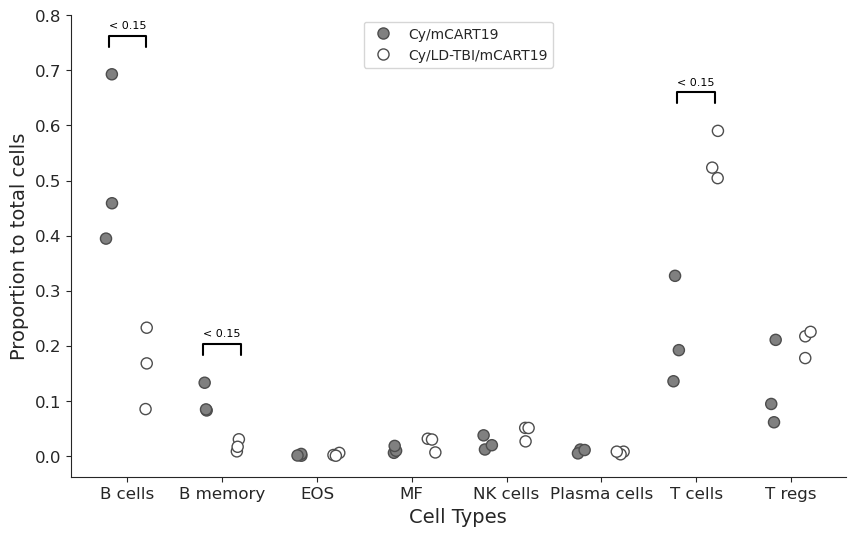

In [63]:
# Threshold and other settings
threshold = 0
plt.figure(figsize=(10, 6))

# Create the box plot
ax = sns.stripplot(
    x="cell_type", 
    y="proportion", 
    hue="Condition", 
    data=melted_prop, 
    #palette=["#BF3EFF", "#FFA500"], 
    palette=["gray", "white"],
    linewidth=1, 
    dodge=True,  # Separate dots by condition
    jitter=True,  # Add jitter to avoid overlap
    size=8
)
# Get x-axis positions for each category
category_positions = {
    text.get_text(): pos for pos, text in enumerate(ax.get_xticklabels())
}

# Annotate significance
for i, param in enumerate(final_parameters_list):
    # Get the current cell type name
    cell_type = melted_prop['cell_type'].cat.categories[i]  # Match plot order

     # Find the x-axis position for this cell type
    if cell_type in category_positions:
        x_pos = category_positions[cell_type]
        
        # Get max y-value for the cell type
        max_y = melted_prop[melted_prop["cell_type"] == cell_type]["proportion"].max()
        y = max_y + 0.05  # Add margin above the max value
        h = 0.02  # Height of the annotation line

        # Determine x-positions for the two conditions
        x1 = x_pos - 0.2  # Adjust for Condition 1
        x2 = x_pos + 0.2  # Adjust for Condition 2

        if param != threshold:
            # Draw the significance annotation
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="black")
            ax.text((x1 + x2) / 2, y + h + 0.01, "< 0.15", 
                    ha="center", va="bottom", color="black", fontsize=8)
        #else:
            # Handle non-significant cases (optional visual adjustment)
            #ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="gray")
            #ax.text((x1 + x2) / 2, y + h + 0.01, "Not-sig", 
                    #ha="center", va="bottom", color="gray", fontsize=8, style="italic")

# Adjust legend position
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((0.5, 1))
    legend.set_loc("center")

# Add labels and legend
ax.set_ylabel("Proportion to total cells",  fontsize=14)
ax.set_xlabel("Cell Types",  fontsize=14)
ax.legend(title="", loc="upper center")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-axis labels
#plt.xticks(rotation=45, ha="right")  # Rotate by 45 degrees, align to the right for readability
ax.tick_params(axis='x', labelsize=12)  # Increase x-axis tick labels
ax.tick_params(axis='y', labelsize=12)  # Increase y-axis tick labels

# Save or display the plot
plt.savefig("color_dotplot_all_cells_scCODA_with_annotations_fixed.pdf", format="pdf", bbox_inches="tight")
plt.show()

